In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp

import utilityfunctions as uf

## Review

The steps to calculate PCA are:
* (If appropriate) normalize the variables to be in the range 0-1
* Center the data
* Compute the covariance matrix
* Compute the eigenvectors and eigenvalues; the eigenvectors tell us the direction of variance, and the eigenvalues tell us the amount of variance
* Get an ordering over the eigenvalues
* Sort the eigenvalues and eigenvectors accordingly
* Compute the proportional variance (how much bigger?) accounted for by each principal component
* Compute the cumulative sum of the proportional variance (tells us how many eigenvectors we need to explain a desired amount of variance)
* Examine the principal components. Select v' of them.
* Project the data into PCA space
* Reconstruct the data

## Today

Today, we are going to look at what happens when we preprocess the data in different ways before fitting a PCA.

So we will look again at the summary statistics for the data.

We will preprocess the data in four ways:
* center only
* minmax global
* minmax local
* zscore

In [2]:
# Things we need from Day 19

# Let's split off the labels
def split(data, ycol):
    y = data[:, ycol]
    xfirst = data[:, 0:ycol]
    xsecond = data[:, ycol+1:data.shape[1]]
    return (np.hstack((xfirst, xsecond)), y)

# center
def center(data):
    centered = data - np.mean(data, axis=0)
    return centered

# preprocess
def preprocess(data, minmax=False, local=False, zscore=False):
    if minmax == True and zscore == True:
        print("Nope, won't do that!")
        return center(data)
    elif zscore == True:
        return uf.zScore(data)   
    elif minmax == True:
        if local == False:
            data = uf.minmaxGlobal(data)
        else:
            data = uf.minmaxLocal(data)
    return center(data)

In [3]:
# This is most of the code from Day 19 in one function; it fits a PCA and prints out all kinds of things along the way
def pca_with_plots(data):
    # covariance
    covariance_matrix = (data.T @ data) / (data.shape[0] - 1)
    print("covariance matrix")
    print(covariance_matrix.shape)

    # Let's look at the covariance matrix
    fig = plt.figure(figsize=(12,12))
    sns.heatmap(pd.DataFrame(covariance_matrix), annot=False, cmap='PuOr')
    plt.show()

    # svd
    (evals, evectors) = np.linalg.eig(covariance_matrix)

    # sort
    evals_order = np.argsort(evals)[::-1]
    evals_sorted = evals[evals_order]
    evectors_sorted = evectors[:, evals_order]

    # proportional variance
    evals_sum = np.sum(evals_sorted)
    proportional_vars = [e / evals_sum for e in evals_sorted]

    # cumulative sum of proportional variance
    cumulative_sum = np.cumsum(proportional_vars)

    # Let's look at the proportional variance
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(proportional_vars)), proportional_vars, alpha=0.5, align='center',
            label='Proportional variance')
    plt.ylabel('Proportional variance ratio')
    plt.xlabel('Ranked Principal Components')
    plt.title("Scree Graph")
    plt.legend(loc='best')
    plt.tight_layout()

    fig = plt.figure(figsize=(6,4))
    ax1 = fig.add_subplot(111)
    ax1.plot(cumulative_sum)
    ax1.set_ylim([0,1.0])
    ax1.set_xlabel('Number of Principal Components')
    ax1.set_ylabel('Cumulative explained variance')
    ax1.set_title('Elbow Plot')
    plt.show()
    
    return evals_sorted, evectors_sorted

In [4]:
# Still our digits data!
data = np.array(np.genfromtxt('data/optdigits/optdigits.tra', delimiter=',', dtype=int)) 
(data, y) = split(data, data.shape[1]-1)

# What are we doing here??
def sums(data):
    y = np.array([np.sum(data[i]) for i in range(data.shape[0])])
    return y

def nonzeros(data):
    y = np.array([(x.shape[0] - np.count_nonzero(x)) / x.shape[0] for x in data])
    return y

data = np.hstack((data, np.array([sums(data), nonzeros(data)]).T))
print("data")
print(data.shape)
print(uf.getSummaryStatistics(data))

data
(3823, 66)
    0         1          2          3          4          5          6   \
0  0.0  8.000000  16.000000  16.000000  16.000000  16.000000  16.000000   
1  0.0  0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2  0.0  0.301334   5.481821  11.805912  11.451478   5.505362   1.387392   
3  0.0  0.751468  21.446112  18.141247  20.584031  31.498206  11.363660   

          7         8          9   ...        56         57         58  \
0  16.000000  5.000000  15.000000  ...  1.000000  10.000000  16.000000   
1   0.000000  0.000000   0.000000  ...  0.000000   0.000000   0.000000   
2   0.142297  0.002093   1.960502  ...  0.000262   0.283024   5.855872   
3   1.105569  0.007843   9.314422  ...  0.000262   0.861043  24.794032   

          59         60         61         62         63           64  \
0  16.000000  16.000000  16.000000  16.000000  16.000000   438.000000   
1   0.000000   0.000000   0.000000   0.000000   0.000000   202.000000   
2  11.942977  11.4

    0             1             2             3             4             5   \
0  0.0  7.698666e+00  1.051818e+01  4.194088e+00  4.548522e+00  1.049464e+01   
1  0.0 -3.013340e-01 -5.481821e+00 -1.180591e+01 -1.145148e+01 -5.505362e+00   
2  0.0 -5.706192e-16  2.961679e-15 -3.805019e-15 -5.324889e-16  1.465506e-15   
3  0.0  7.514683e-01  2.144611e+01  1.814125e+01  2.058403e+01  3.149821e+01   

             6             7             8             9   ...            56  \
0  1.461261e+01  1.585770e+01  4.997907e+00  1.303950e+01  ...  9.997384e-01   
1 -1.387392e+00 -1.422966e-01 -2.092597e-03 -1.960502e+00  ... -2.615747e-04   
2  1.089430e-15  3.498233e-16  1.070564e-16 -8.191779e-16  ...  9.031407e-18   
3  1.136366e+01  1.105569e+00  7.842861e-03  9.314422e+00  ...  2.615063e-04   

             57            58            59            60            61  \
0  9.716976e+00  1.014413e+01  4.057023e+00  4.538844e+00  9.299503e+00   
1 -2.830238e-01 -5.855872e+00 -1.194298e+01 -1.1

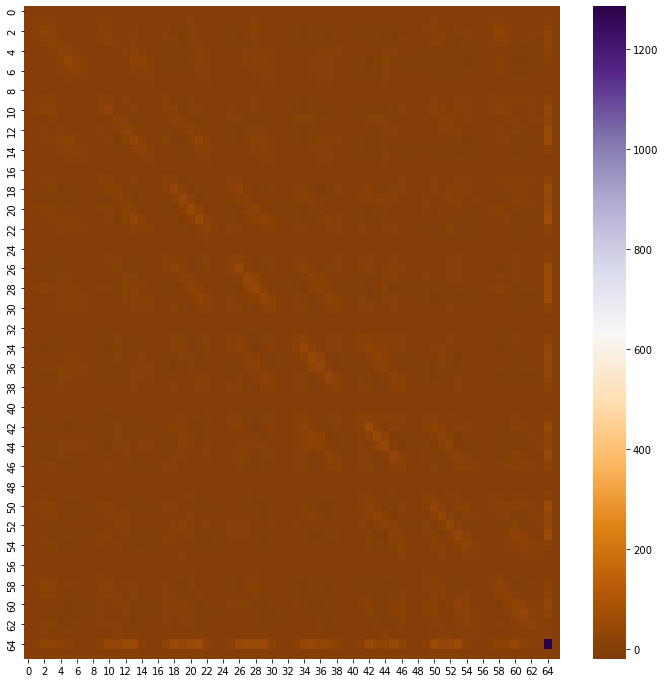

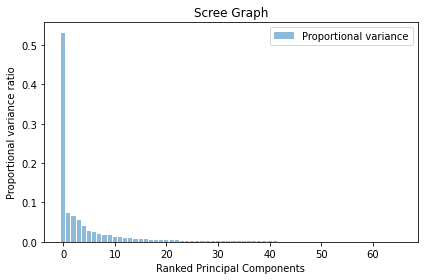

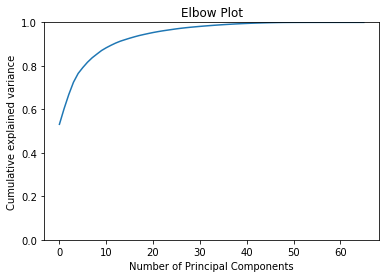

(array([ 1.32271778e+03,  1.79412778e+02,  1.61663618e+02,  1.40637607e+02,
         1.00604656e+02,  6.80539394e+01,  6.09081194e+01,  5.10490099e+01,
         4.20468854e+01,  4.08397449e+01,  3.18213310e+01,  2.77861446e+01,
         2.55483376e+01,  2.16581748e+01,  1.74011651e+01,  1.67998452e+01,
         1.55398608e+01,  1.44792200e+01,  1.22591575e+01,  1.16683804e+01,
         1.10692919e+01,  9.88684911e+00,  8.99214546e+00,  7.96238547e+00,
         7.74481687e+00,  7.70419213e+00,  6.76031282e+00,  6.07128984e+00,
         5.40388830e+00,  4.92724845e+00,  4.81044053e+00,  4.42476985e+00,
         4.20539353e+00,  4.02211653e+00,  3.73595099e+00,  3.57554653e+00,
         3.22967268e+00,  3.11834978e+00,  2.82985034e+00,  2.69246319e+00,
         2.32205104e+00,  2.15791112e+00,  1.84584117e+00,  1.63331744e+00,
         1.54095070e+00,  1.30045559e+00,  1.06489151e+00,  8.99855387e-01,
         7.01155884e-01,  2.80686171e-01,  2.47147034e-01,  1.16570915e-01,
         1.0

In [5]:
# Now center the data, print summary statistics, and then fit a PCA
# What do we observe?
centered = preprocess(data)
print(uf.getSummaryStatistics(centered))
pca_with_plots(centered)

    0             1             2             3             4             5   \
0  0.0  1.757686e-02  2.401411e-02  9.575544e-03  1.038475e-02  2.396036e-02   
1  0.0 -6.879772e-04 -1.251557e-02 -2.695414e-02 -2.614493e-02 -1.256932e-02   
2  0.0  1.052723e-19  8.857390e-19  8.421781e-19 -2.439412e-18  1.172515e-18   
3  0.0  3.917080e-06  1.117893e-04  9.456249e-05  1.072957e-04  1.641866e-04   

             6             7             8             9   ...            56  \
0  3.336212e-02  3.620480e-02  1.141075e-02  2.977054e-02  ...  2.282508e-03   
1 -3.167562e-03 -3.248781e-04 -4.777620e-06 -4.476032e-03  ... -5.972025e-07   
2  4.392394e-19  5.808125e-20 -4.537597e-22  4.356093e-20  ...  3.970398e-22   
3  5.923386e-05  5.762855e-06  4.088145e-08  4.855206e-05  ...  1.363119e-09   

             57            58            59            60            61  \
0  2.218488e-02  2.316011e-02  9.262610e-03  1.036266e-02  2.123174e-02   
1 -6.461731e-04 -1.336957e-02 -2.726707e-02 -2.6

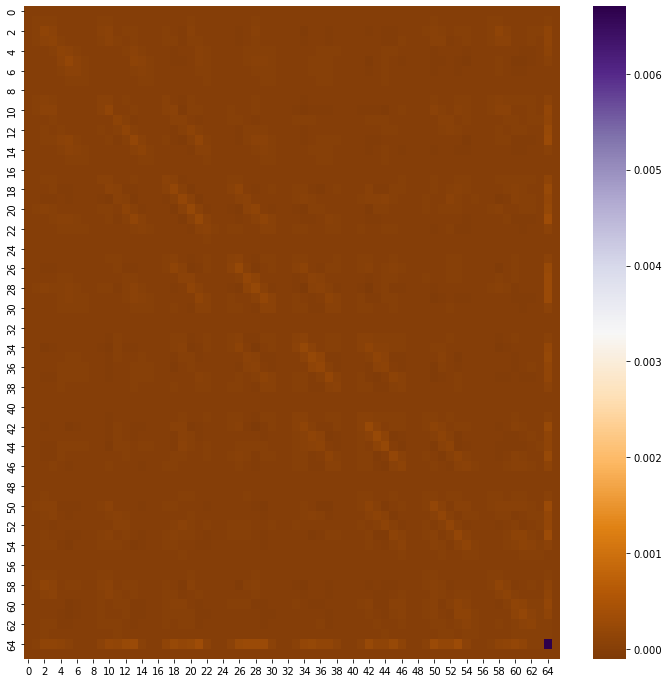

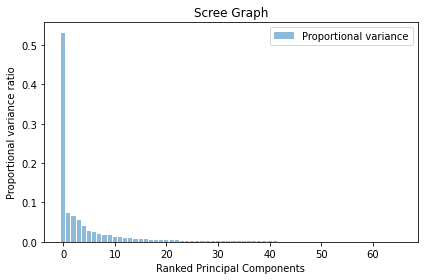

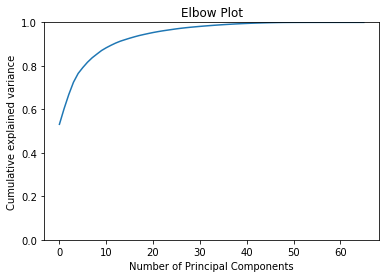

(array([ 6.89475707e-03,  9.35201401e-04,  8.42682688e-04,  7.33083165e-04,
         5.24408665e-04,  3.54735824e-04,  3.17487747e-04,  2.66096463e-04,
         2.19172272e-04,  2.12879970e-04,  1.65870869e-04,  1.44837183e-04,
         1.33172461e-04,  1.12894721e-04,  9.07047660e-05,  8.75703448e-05,
         8.10025894e-05,  7.54739267e-05,  6.39016989e-05,  6.08222326e-05,
         5.76994427e-05,  5.15358787e-05,  4.68721746e-05,  4.15044800e-05,
         4.03703888e-05,  4.01586296e-05,  3.52385939e-05,  3.16470144e-05,
         2.81681382e-05,  2.56836203e-05,  2.50747510e-05,  2.30644161e-05,
         2.19209021e-05,  2.09655581e-05,  1.94739006e-05,  1.86377814e-05,
         1.68348902e-05,  1.62546120e-05,  1.47507889e-05,  1.40346489e-05,
         1.21038502e-05,  1.12482596e-05,  9.62157361e-06,  8.51377909e-06,
         8.03231114e-06,  6.77871389e-06,  5.55082000e-06,  4.69055789e-06,
         3.65482311e-06,  1.46309591e-06,  1.28827086e-06,  6.07633884e-07,
         5.4

In [6]:
# Now preprocess the data via minmax global and center, print summary statistics, and then fit a PCA
# What do we observe?
centered = preprocess(data, minmax=True)
print(uf.getSummaryStatistics(centered))
pca_with_plots(centered)

    0             1             2             3             4             5   \
0  0.0  9.623332e-01  6.573862e-01  2.621305e-01  2.842826e-01  6.559149e-01   
1  0.0 -3.766675e-02 -3.426138e-01 -7.378695e-01 -7.157174e-01 -3.440851e-01   
2  0.0  2.787900e-18 -3.066690e-17  6.017217e-17  3.624270e-17 -3.020225e-18   
3  0.0  1.174169e-02  8.377388e-02  7.086425e-02  8.040637e-02  1.230399e-01   

             6             7             8             9   ...            56  \
0  9.132880e-01  9.911065e-01  9.995815e-01  8.692999e-01  ...  9.997384e-01   
1 -8.671201e-02 -8.893539e-03 -4.185195e-04 -1.307001e-01  ... -2.615747e-04   
2 -5.808125e-19  2.904062e-19  5.808125e-20  1.672740e-17  ... -2.904062e-20   
3  4.438930e-02  4.318629e-03  3.137145e-04  4.139743e-02  ...  2.615063e-04   

             57            58            59            60            61  \
0  9.716976e-01  6.340080e-01  2.535640e-01  2.836777e-01  5.812189e-01   
1 -2.830238e-02 -3.659920e-01 -7.464360e-01 -7.1

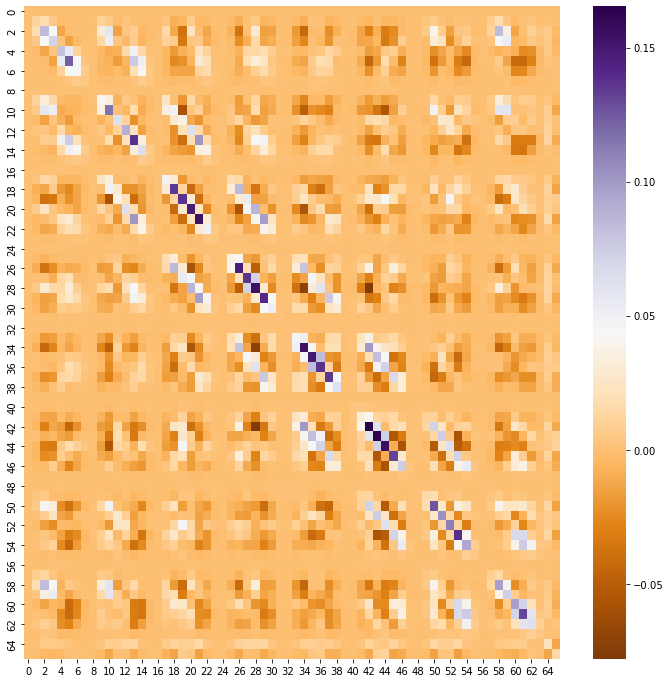

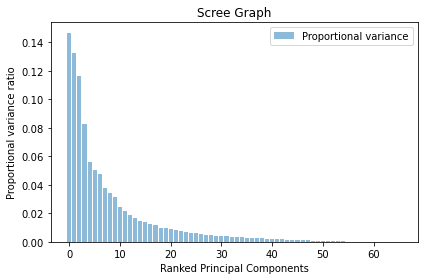

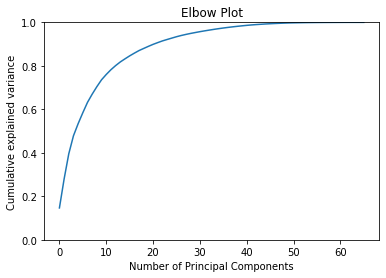

(array([7.02617733e-01, 6.36136819e-01, 5.57809966e-01, 3.96755338e-01,
        2.67344542e-01, 2.41250680e-01, 2.28627566e-01, 1.80666338e-01,
        1.65252112e-01, 1.51756985e-01, 1.16368448e-01, 1.04846807e-01,
        9.07514488e-02, 8.05855394e-02, 6.84082305e-02, 6.57279721e-02,
        5.98875252e-02, 5.71210805e-02, 4.67709552e-02, 4.61567174e-02,
        4.37866341e-02, 3.88926321e-02, 3.70940137e-02, 3.14498210e-02,
        3.05436971e-02, 3.03221527e-02, 2.67889078e-02, 2.38230745e-02,
        2.17163412e-02, 1.97849348e-02, 1.92292161e-02, 1.79355974e-02,
        1.67460404e-02, 1.64062187e-02, 1.53080921e-02, 1.44506996e-02,
        1.32945752e-02, 1.24280468e-02, 1.15482286e-02, 1.07155011e-02,
        1.03961927e-02, 9.11287033e-03, 7.83479612e-03, 6.88402843e-03,
        6.56159720e-03, 5.70449716e-03, 5.01033607e-03, 4.38622690e-03,
        4.16504257e-03, 3.61789710e-03, 2.39436037e-03, 1.95675701e-03,
        1.90786903e-03, 1.43325168e-03, 1.08864827e-03, 9.079227

In [7]:
# Now preprocess the data via minmax local and center, print summary statistics, and then fit a PCA
# What do we observe?
centered = preprocess(data, minmax=True, local=True)
print(uf.getSummaryStatistics(centered))
pca_with_plots(centered)

    0             1             2             3             4             5   \
0  0.0  8.880965e+00  2.271257e+00  9.847002e-01  1.002548e+00  1.869927e+00   
1  0.0 -3.476105e-01 -1.183724e+00 -2.771826e+00 -2.524041e+00 -9.809412e-01   
2  0.0  2.602040e-17 -4.367710e-17  4.358417e-16 -6.133380e-17 -5.064685e-17   
3  0.0  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

             6             7             8             9   ...            56  \
0  4.334796e+00  1.508160e+01  5.643531e+01  4.272508e+00  ...  6.182233e+01   
1 -4.115666e-01 -1.353324e-01 -2.362917e-02 -6.423761e-01  ... -1.617539e-02   
2 -2.880830e-17 -9.292999e-18 -9.292999e-18 -2.509110e-17  ...  5.575800e-18   
3  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  ...  1.000000e+00   

             57            58            59            60            61  \
0  1.047174e+01  2.037235e+00  9.361049e-01  9.093544e-01  1.610287e+00   
1 -3.050075e-01 -1.176029e+00 -2.755685e+00 -2.2

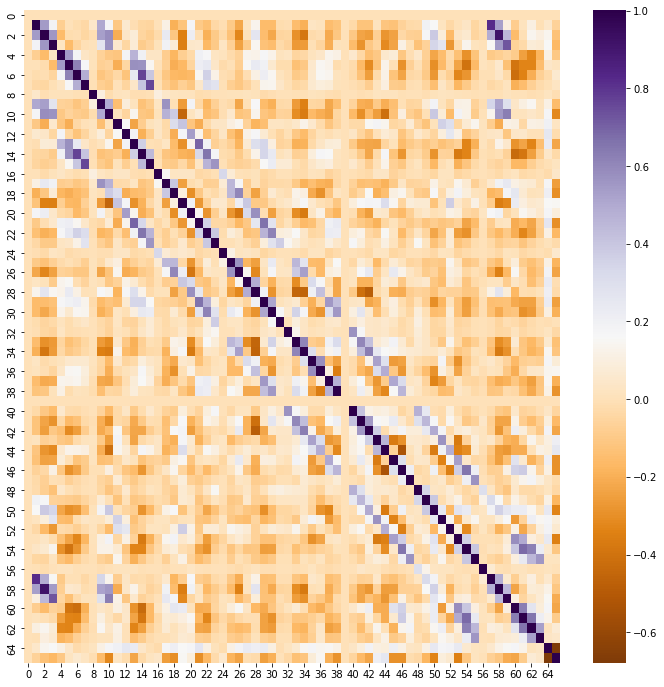

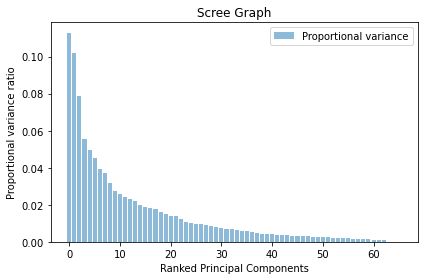

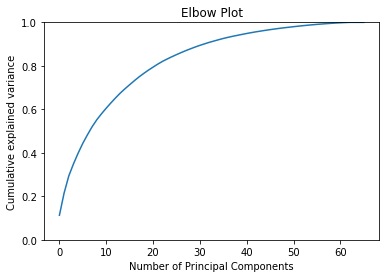

(array([ 7.22513819e+00,  6.53539600e+00,  5.03450550e+00,  3.54561646e+00,
         3.18113122e+00,  2.89772636e+00,  2.53032740e+00,  2.37624390e+00,
         2.04888157e+00,  1.74960095e+00,  1.63572647e+00,  1.54848658e+00,
         1.48494424e+00,  1.41124642e+00,  1.26050655e+00,  1.19363846e+00,
         1.17299702e+00,  1.12690771e+00,  1.01633445e+00,  9.71320344e-01,
         8.89134264e-01,  8.80902987e-01,  8.03876713e-01,  7.01583746e-01,
         6.60750433e-01,  6.32008152e-01,  6.05093048e-01,  5.80249308e-01,
         5.38986354e-01,  5.18767394e-01,  4.88905524e-01,  4.47153285e-01,
         4.34823439e-01,  3.91335042e-01,  3.87363102e-01,  3.70218912e-01,
         3.31182875e-01,  3.03474385e-01,  2.80611816e-01,  2.79843389e-01,
         2.71467822e-01,  2.50811059e-01,  2.41929069e-01,  2.19422613e-01,
         2.14160493e-01,  2.04497822e-01,  1.90611674e-01,  1.86948819e-01,
         1.70249589e-01,  1.59604827e-01,  1.59118171e-01,  1.50558403e-01,
         1.4

In [8]:
# Now preprocess the data via zscoring, print summary statistics, and then fit a PCA
# What do we observe?
centered = preprocess(data, zscore=True)
print(uf.getSummaryStatistics(centered))
pca_with_plots(centered)

Some interesting ties between QR decomposition, SVD and PCA:
* https://python.quantecon.org/qr_decomp.html